In [1]:
import trainHelper
import utils
from mds.lmds import landmarkMDS
from mds.cmds import classicalMDS
from mds.fastmap import fastmap
import numpy
from torch.utils.data import DataLoader
import torch
from torch import nn, Tensor
import lossFunction as lossF
from model.AutoEncoder import AutoEncoder
from model.DynParam import DynParam
from model.Linear import Linear
from model.VAE import VAE
import os.path

In [30]:
import sys
from importlib import reload
reload(sys.modules['utils'])
reload(sys.modules['trainHelper'])
reload(sys.modules['lossFunction'])

<module 'lossFunction' from 'e:\\CityU\\FYP\\lossFunction.py'>

In [3]:
torch.set_default_tensor_type('torch.DoubleTensor')


In [4]:

sample_space = (1000000, 100)
ss, N, d = 800, 20, 2

try:
    euclidean_data = utils.load_variable('data/euclidean_data.pkl')
    rand_data = utils.load_variable('data/rand_data.pkl')

    if euclidean_data.size() != (ss, 1, N, N):
        print("Updated data for requirement !")
        raise Exception("Previous data not match requirement !")

except:
    euclidean_data = utils.generate_euclidean_DM(
        N=N, d=d,
        sample_size=ss,
        sample_space=sample_space, isInt=True)

    rand_data = utils.generate_rand_DM(
        N=N,
        sample_size=ss,
        sample_space=sample_space, isInt=True)

    utils.dump_variable(euclidean_data, 'data/euclidean_data.pkl')
    utils.dump_variable(rand_data, 'data/rand_data.pkl')

In [5]:
data = torch.stack([
            euclidean_data.view(ss, 1, N*N),
            rand_data.view(ss, 1, N*N)
        ]).view(ss * 2, 1, N * N)

data = torch.tensor(data.data, requires_grad=True)

In [31]:
target_dim = 2

model = VAE([N * N, 32, 32, N * target_dim], final_activation=nn.Sigmoid)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

lossFun = lossF.VAELoss(target_dim=(N, target_dim))

helper = trainHelper.TrainHelper(
    id="Linear_with_two_32_layers",
    model=model,
    optimizer=optimizer,
    lossFun=lossFun,
    lr_factor=0.1)

In [25]:
batch = 32
dlr = DataLoader(data, batch_size=batch, shuffle=True)

In [32]:
EPOCH = 500
print_on_each = 5

time_used = utils.time_measure(helper.train, 
                    [dlr, EPOCH, print_on_each])[1]

print("Time used for the training: ", time_used, "s")

helper.backup()

0 	| Mean loss: 7750.829669439691
5 	| Mean loss: 7483.661521222009
10 	| Mean loss: 7473.517831585518
15 	| Mean loss: 7469.724032315284
20 	| Mean loss: 7466.733039274883
25 	| Mean loss: 7463.056037849493
30 	| Mean loss: 7457.08133364359
35 	| Mean loss: 7453.8611238249205
40 	| Mean loss: 7452.742305938774
45 	| Mean loss: 7451.042613081277
50 	| Mean loss: 7449.661966130737
55 	| Mean loss: 7450.89047856982
60 	| Mean loss: 7450.357914711146
65 	| Mean loss: 7442.428658118755
70 	| Mean loss: 7440.0460125547825
75 	| Mean loss: 7439.636571566133
80 	| Mean loss: 7439.719800542831
85 	| Mean loss: 7440.232429668103
90 	| Mean loss: 7439.489732467012
95 	| Mean loss: 7438.446281987154
100 	| Mean loss: 7439.068515794233
105 	| Mean loss: 7439.023581799228
110 	| Mean loss: 7439.180360770398
115 	| Mean loss: 7438.991028226962
120 	| Mean loss: 7438.460070052787
125 	| Mean loss: 7438.84759040443
130 	| Mean loss: 7438.135853650406
135 	| Mean loss: 7438.470264967184
140 	| Mean los

KeyboardInterrupt: 

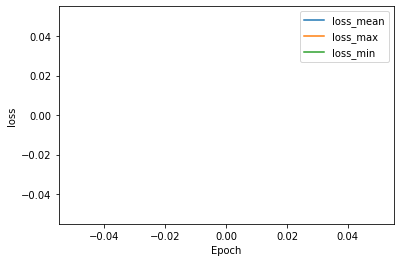

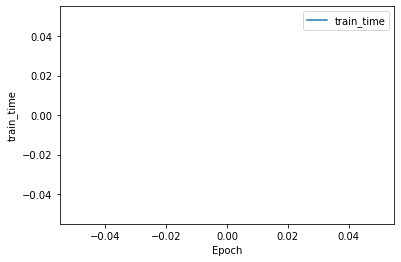

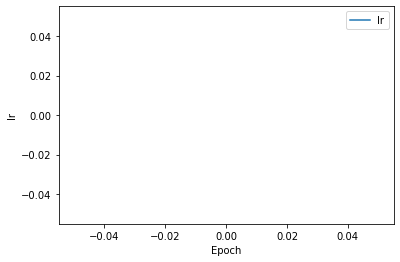

In [9]:
helper.plot(['loss_mean', 'loss_max', 'loss_min'], value_label='loss')
helper.plot(['train_time'], value_label='train_time')
helper.plot(['lr'], value_label='lr')

In [10]:
test_data = utils.generate_rand_DM(
    N=N,
    sample_size=200,
    sample_space=sample_space, isInt=True)


In [11]:

cmds_loss, fastmap_loss, model_loss = [], [], []

with torch.no_grad():

    for d in test_data:

        d1 = numpy.array(d[0].data)

        cmds_rs = classicalMDS(d1, 2)
        cmds_rs = torch.tensor(cmds_rs)
        cmds_dm, _ = utils.get_distance_matrix(cmds_rs)
        cmds_loss.append(torch.sum((cmds_dm - d)** 2))

        fastmap_rs = fastmap(d1, 2)
        fastmap_rs = torch.tensor(fastmap_rs)
        fastmap_dm, _ = utils.get_distance_matrix(fastmap_rs)
        fastmap_loss.append(torch.sum((fastmap_dm - d)** 2))

        d2 = d.view(1, 1, N * N)

        model_rs = model(d2)[2].view(1, N, 2)
        model_dm, _ = utils.get_distance_matrix(model_rs)
        model_loss.append(torch.sum((model_dm - d) ** 2))
        
    print("cmds_loss: \t", torch.tensor(cmds_loss).mean())
    print("fastmap_loss: \t", torch.tensor(fastmap_loss).mean())
    print("model_loss: \t", torch.tensor(model_loss).mean())    


AttributeError: 'tuple' object has no attribute 'view'

In [12]:
utils.plot_2D_coords(
    {
        'cmds': cmds_rs,
        'fastmap': fastmap_rs,
        'model': model_rs
    }
)

NameError: name 'model_rs' is not defined

In [18]:
helper.model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=400, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=400, bias=True)
  )
  (final_act): Tanh()
  (e1): Linear(in_features=32, out_features=40, bias=True)
  (e2): Linear(in_features=32, out_features=40, bias=True)
)

In [23]:
torch.nn.functional.sigmoid(helper.model(d.view(1, 1, N * N))[0])

tensor([[[-1.5518e-01, -9.3135e-02,  3.1004e-02,  6.9949e-02, -3.3851e-02,
           9.8981e-03,  4.7884e-02, -2.1276e-01,  2.0399e-01,  1.2886e-01,
           3.7931e-02, -5.5974e-02, -7.3166e-02,  3.1334e-02,  1.3351e-01,
          -5.6768e-03, -3.1966e-02, -8.9586e-02, -1.2460e-01,  2.4273e-02,
          -1.8733e-01,  5.7409e-02, -7.0224e-02,  4.8430e-02, -1.9106e-01,
          -7.6211e-02,  1.4172e-01,  7.2474e-02,  2.0919e-01,  1.1838e-02,
          -8.1670e-02,  1.2311e-01,  1.2223e-01, -1.6151e-01,  2.7498e-02,
           8.0317e-02,  2.0564e-01, -1.8387e-01, -1.5291e-01,  1.2953e-01,
           1.4691e-01,  1.5232e-01,  8.5879e-02, -1.3605e-01,  1.6771e-01,
           2.3933e-02,  4.6484e-02, -4.0757e-02, -1.2902e-02, -1.3300e-02,
           8.1573e-02,  2.1152e-01,  5.2296e-02,  7.1531e-02, -5.0185e-02,
          -9.8766e-02,  1.2573e-01, -1.3492e-03, -6.3168e-02,  1.6382e-01,
          -6.3830e-02,  1.6126e-01,  4.1947e-02, -3.1373e-02,  2.4855e-02,
          -5.8313e-02, -1